In [ ]:
import wandb
import os 

os.environ['WANDB_NOTEBOOK_NAME'] =
%env WANDB_API_KEY =

wandb.login()

In [69]:
import torch
import matplotlib.pyplot as plt
import numpy as np


In [70]:
from utils import (
    save_checkpoint,
    load_checkpoint,
    check_accuracy,
    save_test_images,
    get_loaders,
    plot_image_mask_pred,
    plot_image_mask_box_pred_box_tolerance,
    get_largest_segments_bounding_box, 
    plot_image_mask_box_pred_box,
    test_dice
)

from models import UNET
from monai.networks.nets import UNet

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [71]:
def calculate_iou_over_under(model, test_image, test_mask, device="cuda"):
    x = test_image.to(device)
    preds = model(x)
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    gt_box = get_largest_segments_bounding_box(test_mask)[0]
    pred_box = get_largest_segments_bounding_box(preds.cpu())[0]

    # Coordinates for the predicted box and ground truth box
    x1_pred, y1_pred, x2_pred, y2_pred = pred_box
    x1_gt, y1_gt, x2_gt, y2_gt = gt_box
    
    # Calculate area of predicted box and ground truth box
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    
    # Calculate intersection coordinates
    x1_int = max(x1_pred, x1_gt)
    y1_int = max(y1_pred, y1_gt)
    x2_int = min(x2_pred, x2_gt)
    y2_int = min(y2_pred, y2_gt)
    
    # Check if there is an intersection
    if x1_int < x2_int and y1_int < y2_int:
        # Calculate the area of intersection
        intersection_area = (x2_int - x1_int) * (y2_int - y1_int)
    else:
        # No intersection
        intersection_area = 0
    
    # Calculate union area
    union_area = pred_area + gt_area - intersection_area
    
    # IoU calculation
    if union_area > 0:
        iou = intersection_area / union_area
    else:
        iou = 0
    
    # Overreach calculation
    overreach = (pred_area - intersection_area) / gt_area if gt_area > 0 else 0
    
    # Underreach calculation
    underreach = (gt_area - intersection_area) / gt_area if gt_area > 0 else 0
    
    return iou, overreach, underreach



In [72]:
import matplotlib.patches as patches
from copy import copy

def calculate_iou_over_under_with_tolerance(model, test_image, test_mask, tolerance, device="cuda"):
    x = test_image.to(device)
    preds = model(x)
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    gt_box = get_largest_segments_bounding_box(test_mask)[0]
    pred_box = get_largest_segments_bounding_box(preds.cpu())[0]

    # Coordinates for the predicted box and ground truth box
    x1_pred, y1_pred, x2_pred, y2_pred = pred_box
    x1_gt, y1_gt, x2_gt, y2_gt = gt_box

    # Add tolerance
    x1_pred, y1_pred, x2_pred, y2_pred = x1_pred - tolerance, y1_pred - tolerance, x2_pred + tolerance, y2_pred + tolerance

    # Calculate area of predicted box and ground truth box
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    
    # Calculate intersection coordinates
    x1_int = max(x1_pred, x1_gt)
    y1_int = max(y1_pred, y1_gt)
    x2_int = min(x2_pred, x2_gt)
    y2_int = min(y2_pred, y2_gt)
    
    # Check if there is an intersection
    if x1_int < x2_int and y1_int < y2_int:
        # Calculate the area of intersection
        intersection_area = (x2_int - x1_int) * (y2_int - y1_int)
    else:
        # No intersection
        intersection_area = 0
    
    # Overreach calculation
    overreach = (pred_area - intersection_area) / pred_area if pred_area > 0 else 0
    
    # Underreach calculation
    underreach = (gt_area - intersection_area) / gt_area if gt_area > 0 else 0

    return overreach, underreach


fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    rect_pred = patches.Rectangle((x1_pred, y1_pred), x2_pred - x1_pred,
                                  y2_pred - y1_pred, linewidth=4, edgecolor='orange', facecolor='none', label='predicted crop without tolerance')
    rect_mask = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2] - gt_box[0],
                                  gt_box[3] - gt_box[1], linewidth=4, edgecolor='dodgerblue', facecolor='none', label='original crop')

    axs[0].imshow(test_image[0, 0], cmap='gray')
    axs[0].set_title('X-ray image', fontsize=20)
    axs[0].axis('off')
    axs[1].imshow(test_mask[0, 0], cmap='gray')
    axs[1].set_title('Original mask', fontsize=20)
    axs[1].axis('off')
    axs[2].imshow(preds[0, 0].cpu(), cmap='gray')
    axs[2].set_title('Predicted mask', fontsize=20)
    axs[2].axis('off')

    for i in [0, 1, 2]:
        pred_rect_copy = copy(rect_pred)
        mask_rect_copy = copy(rect_mask)
        axs[i].add_patch(mask_rect_copy)
        axs[i].add_patch(pred_rect_copy)

    plt.legend(prop={'size': 20})
    plt.show()

In [103]:
Own_unet = UNET(in_channels=1, out_channels=1, features= [16, 32, 64, 128]).to(DEVICE)
load_checkpoint(Own_unet, f'/home/alex/Documents/new try/Data/Lung Unet/save_states/Own_Unet_gaussian_10.pth.tar') #/home/alex/Documents/new try/Data/Lung Unet/save_states/Own_Unet_gaussian_10.pth.tar')# # 
Monai_unet = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=(16, 32, 64, 128), strides=(2, 2, 2), bias = False, num_res_units = 0).to(device=DEVICE)
load_checkpoint(Monai_unet, r'/home/alex/Documents/new try/Data/Lung Unet/save_states/Monai_Unet_gaussian1_1.pth.tar')

model = Own_unet

#from simulated_lung_dataset_gaussian_std import get_loaders_simulated
#train_loader, test_loader, validation_loader = get_loaders_simulated(batch_size = 1, image_std= 10, noise_std_ratio= 0.5)

from simulated_lung_dataset_gaussian import get_loaders_simulated
train_loader, test_loader, validation_loader = get_loaders_simulated(batch_size=1)

=> Loading checkpoint
=> Loading checkpoint


save as dicom

In [98]:
overreachs, underreachs = [], []
tolerance = 0

for image, mask in test_loader:
    overreach, underreach = calculate_iou_over_under_with_tolerance(model, image, mask, tolerance=tolerance, device="cuda")
    overreachs.append(overreach)
    underreachs.append(underreach)

In [99]:

overreachs = 100*np.array(overreachs)
underreachs = 100*np.array(underreachs)

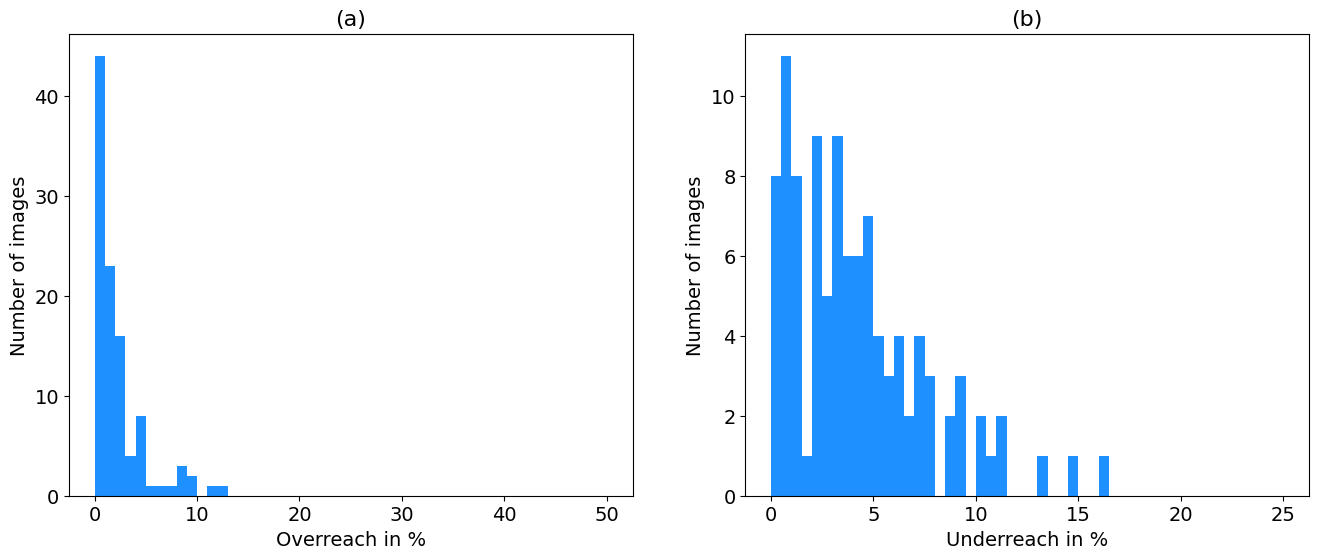

In [100]:

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].hist(overreachs, bins = 50, color = 'dodgerblue', range = (0, 50))#, range = (0, 0.5))
axs[0].set_title('(a)', size = 16)
axs[0].set_xlabel('Overreach in %', size = 14)
axs[0].set_ylabel('Number of images', size = 14)
axs[0].tick_params(axis='both', labelsize=14)
axs[1].hist(underreachs, bins = 50, color = 'dodgerblue', range = (0, 25))#, range = (0, 0.5))
axs[1].set_title('(b)', size = 16)
axs[1].set_xlabel('Underreach in %', size = 14)
axs[1].set_ylabel('Number of images', size = 14)
axs[1].tick_params(axis='both', labelsize=14)
#plt.savefig(r'/home/alex/Documents/Images_thesis/monai_unet_overreach_underreach_without_tolerance.svg', bbox_inches="tight", format="svg")
plt.show()



In [110]:
overreachs, underreachs = [], []
tolerance = 10

for image, mask in test_loader:
    overreach, underreach = calculate_iou_over_under_with_tolerance(model, image, mask, tolerance=tolerance, device="cuda")
    overreachs.append(overreach)
    underreachs.append(underreach)
overreachs = 100*np.array(overreachs)
underreachs = 100*np.array(underreachs)

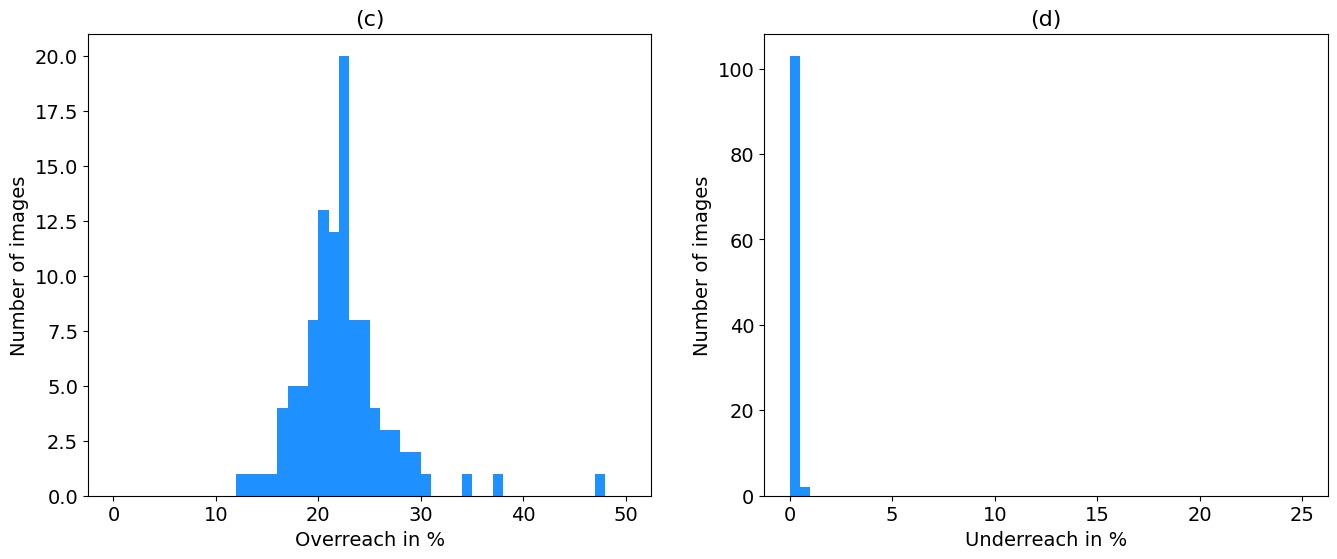

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].hist(overreachs, bins = 50, color = 'dodgerblue', range = (0, 50))#, range = (0, 0.5))
axs[0].set_title('(c)', size = 16)
axs[0].set_xlabel('Overreach in %', size = 14)
axs[0].set_ylabel('Number of images', size = 14)
axs[0].tick_params(axis='both', labelsize=14)
axs[1].hist(underreachs, bins = 50, color = 'dodgerblue', range = (0, 25))#, range = (0, 0.5))
axs[1].set_title('(d)', size = 16)
axs[1].set_xlabel('Underreach in %', size = 14)
axs[1].set_ylabel('Number of images', size = 14)
axs[1].tick_params(axis='both', labelsize=14)
#plt.savefig(r'/home/alex/Documents/Images_thesis/our_unet_overreach_underreach_with_tolerance.svg', bbox_inches="tight", format="svg")
plt.show()

In [112]:
underreachs

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     